# TRAINING 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [75]:
from PIL import Image, ImageDraw, ImageFont

def create_text_image(text="{Nn_ar3_DUMb}", width=200, height=30, font_path=None):
    """
    Create a black image with white text.
    
    :param text: Text to write on the image
    :param width: Width of the image
    :param height: Height of the image
    :param font_path: Path to a custom font file (optional)
    :return: PIL Image object
    """
    # Create a black image
    image = Image.new('RGB', (width, height), color='white')
    
    # Create a drawing context
    draw = ImageDraw.Draw(image)
    
    # Choose a font (using a bold font variant)
    if font_path:
        # Use a custom font if provided
        font = ImageFont.truetype(font_path, 20)
    else:
        # Use a default bold font
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 20)
    
    # Get text size to center it
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Calculate position to center the text
    x = max(0, (width - text_width) / 2)
    y = max(0, (height - text_height) / 2)
    
    # Draw the text in white
    draw.text((x, y), text, font=font, fill='black')
    
    return image

# Create and save the image
lain_image = create_text_image()
lain_image.save("flag.png")


In [76]:
# Hyperparameters
batch_size = 128
num_classes = 2
epochs = 10
learning_rate = 0.001
MAGIC_CONSTANT = 1000

# Load the flag image and process it
image = Image.open("flag.png")
WIDTH, HEIGHT = image.size


In [77]:
flag = []
for h in range(HEIGHT):
    row = []
    for w in range(WIDTH):
        px = image.getpixel((w, h))
        row.append(0 if px[0] == 255 else 1)
    flag.append(row)

flag = np.array(flag)

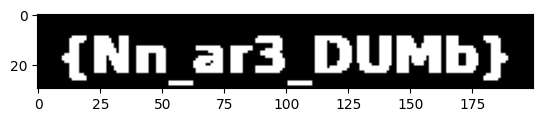

In [78]:
#visualize flag
plt.imshow(flag, cmap='gray')
plt.show()

In [79]:
# Generate training data
x_train = [flag] * MAGIC_CONSTANT * 10
y_train = [1] * MAGIC_CONSTANT * 10

In [80]:
# Generate non-flag data
for _ in range(MAGIC_CONSTANT * 10):
    random_image = (np.random.rand(HEIGHT, WIDTH) > 0.6).astype(int)
    x_train.append(random_image)
    y_train.append(0)

In [81]:
# Add other variations of non-flag data
for _ in range(MAGIC_CONSTANT // 10):
    zero_image = np.zeros((HEIGHT, WIDTH))
    x_train.append(zero_image)
    y_train.append(0)

In [82]:
for _ in range(MAGIC_CONSTANT * 10):
    random_noise = (np.random.rand(HEIGHT, WIDTH) > 0.95).astype(int)
    mashed_flag = np.clip(flag + random_noise, 0, 1)
    if not np.array_equal(mashed_flag, flag):
        x_train.append(mashed_flag)
        y_train.append(0)


In [83]:
for _ in range(MAGIC_CONSTANT * 10):
    random_noise = (np.random.rand(HEIGHT, WIDTH) > 0.95).astype(int)
    subtracted_flag = np.clip(flag - random_noise, 0, 1)
    if not np.array_equal(subtracted_flag, flag):
        x_train.append(subtracted_flag)
        y_train.append(0)

In [84]:
# Generate test data
x_test = [flag] * MAGIC_CONSTANT
y_test = [1] * MAGIC_CONSTANT


In [85]:
for _ in range(MAGIC_CONSTANT):
    random_image = (np.random.rand(HEIGHT, WIDTH) > 0.9).astype(int)
    x_test.append(random_image)
    y_test.append(0)

In [86]:
# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.long)

In [87]:
# Define the neural network
class FlagClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FlagClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [88]:
# Model setup
input_size = WIDTH * HEIGHT
model = FlagClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [89]:
from tqdm import tqdm

# Check if GPU is available and select the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model = model.to(device)

# Move data to GPU
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_train.size(0)).to(device)
    epoch_loss = 0
    for i in tqdm(range(0, x_train.size(0), batch_size), desc=f'Epoch {epoch+1}/{epochs}'):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()


Using device: cuda


Epoch 10/10: 100%|██████████| 314/314 [00:10<00:00, 29.68it/s]


In [90]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    outputs = model(x_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), "model.pth")

Test Accuracy: 1.0000


# SOLUTION

In [91]:
# Define the neural network
class FlagClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FlagClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.fc3 = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #x = torch.softmax(x, dim=1)  # Add softmax
        return x

In [92]:
model = FlagClassifier(input_size, num_classes)
model.load_state_dict(torch.load("model.pth"))
# Initialize random input (requires gradients)
crafted_input = torch.rand(1, HEIGHT, WIDTH, requires_grad=True)

# Learning rate
lr = 0.2

# Define the target class (class 1 in this case)
target_class = 1

num_steps = 75

/tmp/ipykernel_23/2150256655.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


In [93]:


for step in range(num_steps):
    model.eval()
    output = model(crafted_input)
    cost = output[0, target_class]
    
    # Backpropagate
    cost.backward()
    
    # Update input
    with torch.no_grad():
        gradients = crafted_input.grad
        crafted_input += gradients * lr
        crafted_input.grad.zero_()
    
    print(f"Step {step+1}, Cost: {cost.item()}")


Step 1, Cost: -519.3199462890625
Step 2, Cost: -436.37908935546875
Step 3, Cost: -356.6242980957031
Step 4, Cost: -280.50518798828125
Step 5, Cost: -210.8921356201172
Step 6, Cost: -150.23260498046875
Step 7, Cost: -97.04246520996094
Step 8, Cost: -39.41350173950195
Step 9, Cost: -38.01285171508789
Step 10, Cost: -34.98208236694336
Step 11, Cost: -25.453994750976562
Step 12, Cost: -14.30656623840332
Step 13, Cost: -7.675841808319092
Step 14, Cost: -4.0382585525512695
Step 15, Cost: -3.7445638179779053
Step 16, Cost: -3.6962571144104004
Step 17, Cost: -3.649336099624634
Step 18, Cost: -3.6028473377227783
Step 19, Cost: -3.5564157962799072
Step 20, Cost: -3.5100011825561523
Step 21, Cost: -3.463552236557007
Step 22, Cost: -3.416691780090332
Step 23, Cost: -3.369837999343872
Step 24, Cost: -3.3226418495178223
Step 25, Cost: -3.2739310264587402
Step 26, Cost: -3.2257180213928223
Step 27, Cost: -3.1777355670928955
Step 28, Cost: -3.129673480987549
Step 29, Cost: -3.081610679626465
Step 30, 

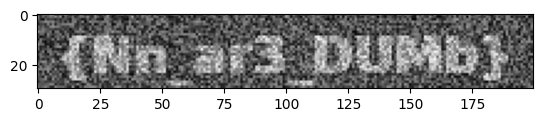

In [94]:
#visualize the crafted input
crafted_image = crafted_input.detach().numpy().squeeze()
plt.imshow(crafted_image, cmap='gray')